In [ ]:
import numpy as np
from numpy import pi, exp, log10
from numpy.fft import fft, fftshift, fftfreq, ifft
from bokeh.plotting import figure, show, output_notebook
import bokeh.palettes as pl
import panel as pn
pn.extension()
from glob import glob
from tqdm import tqdm 
import os

import utils

import matplotlib.pyplot as plt
import scipy

In [ ]:
fs, x1 = scipy.io.wavfile.read('freebird.wav')
x1 = np.array(x1, dtype=np.float32)
fs, x1.shape

FS = 44100
stft = utils.get_stft(fs=FS)

# cut down waveform size to two minutes centered around the start of the freebird solo
start = 5*60 + 41 #+ 30
end = 7*60 + 41 #- 30
x = x1[start*fs:end*fs]

l = x[:, 0]
r = x[:, 1]
scipy.io.wavfile.write('freebird_cut.wav', fs, np.array([l, r]).T.astype(np.int16))


s = (l + r) / 2 # mono signal
N = len(l)

P_IID, P_IC = utils.encode(stft, l, r)
y_mixed = utils.decode(stft, s, P_IID, P_IC)
l1 = y_mixed.T[:, 0]
r1 = y_mixed.T[:, 1]
scipy.io.wavfile.write('freebird_decoded.wav', fs, y_mixed.T.astype(np.int16))

In [ ]:
import ffmpeg

files = glob('./data/**/**.mp3')

# convert all to wav
for f in tqdm(files):
    out = f.replace('.mp3', '.wav')
    ffmpeg.input(f).output(out).run(overwrite_output=True, quiet=True)

In [ ]:
files = glob('./data/**/**.wav')

# mark any file that won't load as .wav.bad
for f in tqdm(files):
    try:
        fs, l, r = utils.load_wav(f)
    except:
        # print(f)
        os.rename(f, f + '.bad')

# reverse the above
# for f in glob('./data/**/**.wav.bad'):
#    os.rename(f, f.replace('.bad', ''))

In [ ]:
files = glob('./data/**/**.wav')

FS = 44100
stft = utils.get_stft(fs=FS)

# generate PS coding, then save as npz
for f in tqdm(files):
    fs, l, r = utils.load_wav(f)
    N = len(l)
    P_IID, P_IC = utils.encode(stft, l, r)
    out = f + '_ps.npz'
    np.savez_compressed(out, P_IID=P_IID, P_IC=P_IC)

# reverse the above
# for f in glob('./data/**/**.wav_ps.npz'):
#    os.remove(f)

In [297]:
import os
from glob import glob
# delete all files with _hat.wav
for f in glob('data/**/**_hat.wav'):
    os.remove(f)

FS = 44100
stft = utils.get_stft(fs=FS)

In [298]:
n_train = 2
n_test = 3
n_frames = 20

train = glob('data/**/**.wav')[:n_train]
test = glob('data/**/**.wav')[n_train:n_train+n_test]
len(train), len(test)

(2, 3)

In [299]:
# train the model

n_samples = 200
features = []
labels = []

from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=1)

for f in tqdm(train):
    if f.find('_hat.wav') > 0: # TODO: really need a more reliable way of doing this
        continue
   
    s, BS, P_IID, P_IC, P, m = utils.file_to_feature_label(f, stft)

    for i in range(n_samples):
        # take a random set of frames from the spectrogram S
        idx = np.random.randint(0, BS.shape[1] - n_frames)

        feature = BS[:, idx:idx+n_frames]
        feature = utils.complex_to_real(feature).flatten()
        features.append(feature)
        
        # the label is the PS parameters of the last frame
        label = P[:, idx+n_frames]
        label = utils.complex_to_real(label)
        labels.append(label)

knn = KNeighborsRegressor(n_neighbors=1).fit(features, labels)
knn

100%|██████████| 2/2 [00:00<00:00,  3.75it/s]


KNeighborsRegressor(n_neighbors=1)

In [300]:
# test the model
for f in test:
    print(f)
    s, BS, P_IID, P_IC, P, m = utils.file_to_feature_label(f, stft)
    P_hat = np.zeros_like(P)

    features = []
    for i in range(BS.shape[1] - n_frames):
        feature = BS[:, i:i+n_frames]
        feature = utils.complex_to_real(feature).flatten()
        features.append(feature)
    
    labels = knn.predict(features)
    for i in range(len(labels)):
        P_hat[:, i+n_frames] = utils.real_to_complex(labels[i])
    
    P_IID_hat, P_IC_hat = utils.parameters_split(P_hat)
    l_hat, r_hat = utils.decode(stft=stft, s=s, P_IID=P_IID_hat, P_IC=P_IC_hat)
    scipy.io.wavfile.write(f.replace('.wav', '_hat.wav'), FS, np.array([l_hat*m, r_hat*m]).astype(np.int16).T)

    # print mse
    # P_IID /= np.linalg.norm(P_IID)
    # P_IC /= np.linalg.norm(P_IC)
    # P_IID_hat /= np.linalg.norm(P_IID_hat)
    # P_IC_hat /= np.linalg.norm(P_IC_hat)

    mse_IID = np.mean(np.abs(P_IID - P_IID_hat)**2)
    mse_IC = np.mean(np.abs(P_IC - P_IC_hat)**2)
    print(f'mse_IID={mse_IID:.2f}, mse_IC={mse_IC:.2f}', mse_IID/mse_IC)

data/008/008345.wav
mse_IID=12.50, mse_IC=0.16 78.80810943144185
data/015/015487.wav
mse_IID=23.55, mse_IC=0.69 33.93273576440886
data/015/015543.wav
mse_IID=45.73, mse_IC=0.29 160.27912495969844


In [301]:
import os
from glob import glob
# delete all files with _hat.wav
for f in glob('data/**/**_hat.wav'):
    os.remove(f)

FS = 44100
stft = utils.get_stft(fs=FS)

In [310]:
n_train = 1
n_test = 1

files = glob('data/**/**.wav')
train = files[:n_train]
test = files[n_train:n_train+n_test]

train_features = np.zeros((n_train, 1294, utils.FREQ_BINS*2))
train_labels = np.zeros((n_train, 1294, utils.FREQ_BINS))

test_features = np.zeros((n_test, 1294, utils.FREQ_BINS*2))
test_labels = np.zeros((n_test, 1294, utils.FREQ_BINS))

for i, f in tqdm(enumerate(train)):
    s, BS, P_IID, P_IC, P, m = utils.file_to_feature_label(f, stft)
    train_features[i] = utils.complex_to_real(BS).T
    train_labels[i] = P_IC.real.T

for i, f in tqdm(enumerate(test)):
    s, BS, P_IID, P_IC, P, m = utils.file_to_feature_label(f, stft)
    test_features[i] = utils.complex_to_real(BS).T
    test_labels[i] = P_IC.real.T

1it [00:00,  3.92it/s]
1it [00:00,  2.70it/s]


In [311]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, LSTM, Conv1D
import keras

model = Sequential()
model.add(Input(shape=(None, utils.FREQ_BINS*2)))


# model.add(SimpleRNN(units=utils.FREQ_BINS*8, return_sequences=True)) #activation=activation[0]))
# model.add(SimpleRNN(units=utils.FREQ_BINS*4, return_sequences=True)) #activation=activation[0]))
# model.add(SimpleRNN(units=utils.FREQ_BINS*8, return_sequences=True)) #activation=activation[0]))
# model.add(SimpleRNN(units=utils.FREQ_BINS*16, return_sequences=True)) #activation=activation[0]))
# model.add(Dense(units=utils.FREQ_BINS))
model.add(SimpleRNN(units=utils.FREQ_BINS*5, return_sequences=True)) #activation=activation[0]))
model.add(Dense(units=utils.FREQ_BINS))
model.add(Dense(units=utils.FREQ_BINS, activation='linear'))
# model.add(LSTM(units=utils.FREQ_BINS*2, return_sequences=True)) #activation=activation[1]))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()


Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_139 (SimpleRNN)      │ (None, None, 170)      │        40,630 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, None, 34)       │         5,814 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, None, 34)       │         1,190 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,634 (186.07 KB)

 Trainable params: 47,634 (186.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(train_features, train_labels, epochs=1000, batch_size=1)

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3255
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 0.2702
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 0.2383
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.2143
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 0.1963
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 0.1825
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.1704
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.1578
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.1418
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 0.1216
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.1063
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.0940
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.0847
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.0785
Epoch 15/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


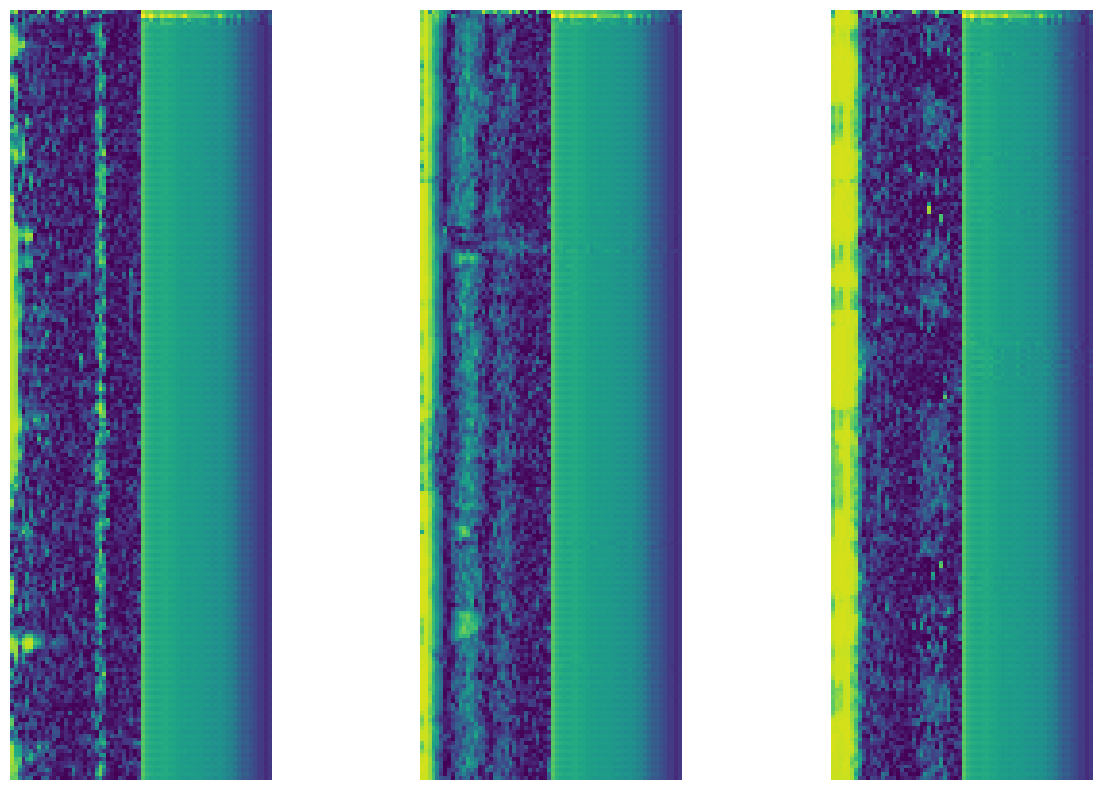

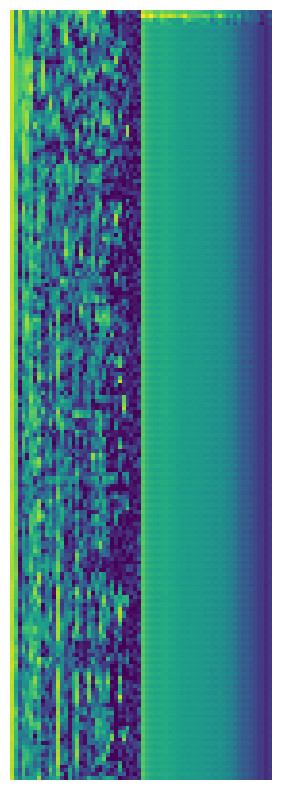

In [ ]:
# model.evaluate(train_features, train_labels, batch_size=1)
# model.evaluate(test_features, test_labels, batch_size=1)
N = 3
plt.figure(figsize=(15, 10))
for i in range(N):
    plt.subplot(1, N, i+1)
    ax = plt.gca()
    ax.set_axis_off()
    real = np.abs(train_labels[i]).round(2)[:200]
    predict = np.abs(model.predict(train_features[i:i+1])[0]).round(2)[:200]
    plt.imshow(np.concatenate([real, predict], axis=1))

N = 1
plt.figure(figsize=(15, 10))
for i in range(N):
    plt.subplot(1, N, i+1)
    ax = plt.gca()
    ax.set_axis_off()
    real = np.abs(test_labels[i]).round(2)[:200]
    predict = np.abs(model.predict(test_features[i:i+1])[0]).round(2)[:200]
    plt.imshow(np.concatenate([real, predict], axis=1))

In [ ]:
for f in test:
    print(f)
    s, BS, P_IID, P_IC, P, m = utils.file_to_feature_label(f, stft)
    P_hat = np.zeros_like(P)

    feature = utils.complex_to_real(BS).T
    # label = utils.complex_to_real(P).T
    
    P_hat = utils.real_to_complex(model.predict(np.array([feature]))[0].T)
    P_IID_hat, P_IC_hat = utils.parameters_split(P_hat)
    l_hat, r_hat = utils.decode(stft=stft, s=s, P_IID=P_IID_hat, P_IC=P_IC_hat)
    scipy.io.wavfile.write(f.replace('.wav', '_hat.wav'), FS, np.array([l_hat*m, r_hat*m]).astype(np.int16).T)

    # print mse
    # P_IID /= np.linalg.norm(P_IID)
    # P_IC /= np.linalg.norm(P_IC)
    # P_IID_hat /= np.linalg.norm(P_IID_hat)
    # P_IC_hat /= np.linalg.norm(P_IC_hat)

    mse_IID = np.mean(np.abs(P_IID - P_IID_hat)**2)
    mse_IC = np.mean(np.abs(P_IC - P_IC_hat)**2)
    print(np.mean(np.abs(P_IID_hat)), np.mean(np.abs(P_IC_hat)), sep='\t')
    print(np.mean(np.abs(P_IID)), np.mean(np.abs(P_IC)), sep='\t')
    print(f'mse_IID={mse_IID:.2f}, mse_IC={mse_IC:.2f}', mse_IID/mse_IC)

In [ ]:
X = 10**(np.abs(P_IID)/10)

This creates the $\mathbf{B}$ matrix which consists of 1s and 0s and sums the 2049 FFT bins into 34 frequency bands

The cross spectrogram is defined as:
$$\rho(\mathbf{X}, \mathbf{Y}) = \mathbf{B}(\mathbf{X} \times \mathbf{Y}^*)$$
where $\times$ denotes element-wise multiplication, and $*$ denotes element-wise complex conjugation.

In [ ]:
from bokeh import palettes as pl
from bokeh.models import LogColorMapper, ColorBar

m = LogColorMapper(palette=pl.Inferno256, low=X.min(), high=X.max())

p = figure(width=1500, height=700, title='Spectrogram', x_axis_label='Time (s)', y_axis_label='Frequency (kHz)')
p.min_border=0

p.image(image=[X], x=0, y=0, dw=X.shape[1]*int(4096*(1-0.75))/fs, dh=fs/2/1e3, color_mapper=m)
p.add_layout(ColorBar(color_mapper=m), 'right')

show(p)